In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules
sys.path.append('semiVAE_all/')
if IN_COLAB:
    !pip3 install scanpy
    !pip3 install leidenalg
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/semiVAE_all/')

In [5]:
import pandas as pd
import scanpy as sc
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import rc_context
from semiVAE import get_gsva,utils,dataloader,poe_trainer,sigvae_trainer,poe_model,get_recon,sigvae_model,plot_utils, postprocess

## claim input file and output path


In [12]:
## path for model folder
root_dir = '/content/drive/MyDrive/SpatialModelProject/semiVAE_all/'

data_folder = 'data'

## data name
sample_id='CID444971'

## variable gene list for data
var_file_name = 'results/00_var_gene_folder/'+sample_id+'_var_sig5000.csv'

## signature table
sig_file_name = 'data/bc_signatures_version_0201.csv'

## gsva file
gsva_file_name = root_dir+'results/01_gsva/'+sample_id+'_gsva.csv'

gsva_save_path = 'results/01_gsva/'+sample_id+'_gsva.csv'

## get gsva

In [11]:
# run gsva
run_gsva = False

if run_gsva:
    gsva_score = get_gsva(sample_id, var_file_name, sig_file_name)
    gsva_score.to_csv(gsva_save_path)
else:
    gsva_score = pd.read_csv(gsva_file_name,index_col=0)

## prepare st data

In [13]:
if sample_id.startswith('MBC'):
    adata_sample = sc.read_visium(path=os.path.join(root_dir,data_folder, sample_id),library_id =  sample_id)
    adata_sample.var_names_make_unique()
    adata_sample.obs['sample']=sample_id
else:
    adata_sample = sc.read_h5ad(os.path.join(root_dir,data_folder,sample_id, sample_id+'.h5ad'))
    adata_sample.var_names_make_unique()
    adata_sample.obs['sample']=sample_id
      
adata_sample = utils.preprocess(adata_sample, n_top_genes=2000) 

Preprocessing1: delete the mt and rp
Preprocessing2: Normalize
Preprocessing3: Logarithm


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing4: Find the variable genes


## Load gene signature

In [14]:
# load signature data [type x gene]
gene_sig = pd.read_csv(os.path.join(root_dir,sig_file_name))

## Get image and image info

In [15]:
# image preparation
adata_image, map_info = utils.preprocess_img(root_dir+data_folder,sample_id,adata_sample.obs.index,hchannal=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


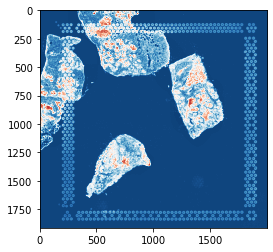

In [16]:
plt.imshow(adata_image,cmap='RdBu_r')

## Clustering

In [ ]:
# Manifold Embedding 
sc.pp.pca(adata_sample)
sc.pp.neighbors(adata_sample)
sc.tl.umap(adata_sample, n_components=3)
sc.tl.leiden(adata_sample, key_added="clusters")

In [ ]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata_sample, color='clusters')
    plot_utils.pl_spatial_cluster(adata_sample,map_info,s=5)

In [ ]:
# define the pure and peri spots
pure_spots, perif_spots = utils.find_spots(adata_sample, gsva_score)
spot_sizes = adata_sample.obs_names.map(lambda x: 500 if x in set(pure_spots) else 50)
sig_genes_dict = {
        sig: gene_sig[sig][~pd.isna(gene_sig)[sig]].tolist() 
        for sig in gene_sig.columns
    }
sig_vars, sig_vars_dict, sel_genes = utils.calc_var_priors(adata_sample, sig_genes_dict) 

for k, v in sig_vars_dict.items():
    print("{0}: {1}".format(k, v))

## run sigVAE

In [ ]:
# prepare dataset for training
variable_gene, sig_gname_filtered, sig_variable_gene_inter = utils.gene_for_train(adata_sample, gene_sig) 
# Discretize gsva scores given different thresholds
gsva_scores_train = utils.discretize_gsva(gsva_score)
adata_train = adata_sample[:, sig_variable_gene_inter]
in_features = adata_train.shape[1]
bn_features = len(sig_vars)

the number of original variable genes in the dataset (2000,)
the number of siganture genes in the dataset (691,)
after filter out some genes in the signature not in the var_names ... (652,)
after filter out some genes not highly expressed in the signature ... (646,)
combine the varibale and siganture, the total unique gene number is ... 2492


In [ ]:
vae_normal = sigvae_model.SignatureVAE(
    c_in=in_features,
    c_bn=bn_features,
    sig_vars_prior=sig_vars,
    n_layers=2,
    posterior='Normal'
)

In [ ]:
losses_normal = sigvae_trainer.train(
    model=vae_normal,
    adata_train=adata_train,
    df_gsva_train=gsva_scores_train,
    pseudo_spots=perif_spots,
    batch_size=128,
)

In [ ]:
torch.save(vae_normal,'/content/drive/MyDrive/SpatialModelProject/semiVAE_all/CID_TNBC.pt')

In [ ]:
vae_normal = torch.load('/content/drive/MyDrive/SpatialModelProject/semiVAE_all/CID_TNBC.pt')

In [ ]:

# Infer latent space & reconstructed gexp with full training dataset (single forward-pass)
x_hat_nb, latent_nb = sigvae_trainer.run_inference(vae_normal, adata_train)

latent_nb.qz_mu_samp = latent_nb.qz_mu[
    np.vectorize(lambda x: adata_train.obs_names.get_loc(x))(perif_spots)
]

df_corr_bn = utils.calc_corr_gsva(
    latent_nb.qz_mu_samp,
    perif_spots,
    gsva_score
)

df_corr = utils.calc_corr_gsva(
    latent_nb.qz_mu,
    gsva_score.index,
    gsva_score
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Deconvolution in spatial coordinates
adata_plot = utils.display_latent(adata_train, gsva_score, vae_normal)

Trying to set attribute `.obs` of view, copying.


In [ ]:
all_loc = np.array(map_info.loc[:,['array_col','array_row']])
for i in range(26):
    fig,axs= plt.subplots(1,1,figsize=(3,3),dpi=200)
    g=axs.scatter(all_loc[:,0],-all_loc[:,1],c=adata_plot[gsva_score.columns[i]],s=2,cmap='Spectral_r',
                  #vmax=2,vmin=-2
                  )
    axs.set_title(gsva_score.columns[i])
    axs.set_xticks([])
    axs.set_yticks([])
    fig.colorbar(g)

In [ ]:
def calc_diag_score(A, eps=1e-10):
    """
    Measure accuracy (how diagonal) a correlation matrix is
    Metrics:
     - F1 score: TP / (TP + 1/2(FP + FN))
    """
    A = np.asarray(A)
    #A[A < 0] = 0
    A = (A-A.min())/(A.max()-A.min())
    tp = np.trace(A)/ A.shape[0] *2
    print('tp=',tp)
    fp_fn = A.sum()/(A.shape[0]*A.shape[1])  #- tp
    print('fp_fn=',fp_fn)
    score = tp / (tp + 0.5 * fp_fn + eps)

    return score

In [ ]:
def display_corr_gsva(df_corr,
                      cluster=False,
                      title=None,
                      size=(12, 20)
                      ):
    """
    Correlation heatmap - Bottle-neck (latent) values vs. GSVA score

    Parameters
    ----------
    df_corr : pd.DataFrame
        DataFrame of correlation between factors & learnt latent variable

    cluster : bool [default=False]
        Whether perform hierarchical clustering on axes
    """
    # Performance metrics: F1-score as diagonalizedness measurement
    score = str(round(calc_diag_score(df_corr), 2))

    # Plotting specs
    sns.set(font_scale=1.5)
    cmap = colormap.get_cmap('RdBu')

    g = sns.clustermap(df_corr, cmap=cmap.reversed(), row_cluster=cluster, col_cluster=cluster)
    g.fig.set_size_inches(size[0], size[1])
    ax = g.ax_heatmap

    ax.set_xticks(np.arange(len(df_corr.columns)))
    ax.set_yticks(np.arange(len(df_corr.index)))
    ax.set_xticklabels(df_corr.columns)
    ax.set_yticklabels(df_corr.index)

    plt.suptitle(title + '; F1-score={}'.format(score))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.cm as colormap

In [ ]:
display_corr_gsva(
    df_corr_bn,
    title='Correlation of BNs with GSVA (sig)',# \nsig_loss={}'.format(str(sig_loss_avg)),
    cluster=False
)

display_corr_gsva(
    df_corr,
    title='Correlation of BNs with GSVA (train, all spots)',
    cluster=False
)


In [ ]:
factor = adata_plot.loc[:,gene_sig.columns]

In [ ]:
import os
from sklearn.cluster import SpectralCoclustering
import json
from scipy.stats import zscore

def bi_cluster(slisa_a):
    model = SpectralCoclustering(n_clusters=11, random_state=0)
    model.fit(slisa_a)
    fit_data = slisa_a.iloc[np.argsort(model.row_labels_)]
    fit_data = fit_data[fit_data.columns[np.argsort(model.column_labels_)]]
    return fit_data,model

In [ ]:
from semiVAE import postprocess

fit_data,model = bi_cluster(factor)

In [ ]:
hub_df = pd.DataFrame(model.row_labels_,index = map_info.index,columns=['hub'])
hub_df = hub_df.reindex(fit_data.index)

In [ ]:
all_loc = map_info.loc[:,['array_col','array_row']]

fig,axs= plt.subplots(1,1,figsize=(3,3),dpi=300)

for i in range(model.row_labels_.max()+1):
  g=axs.scatter(np.array(all_loc[hub_df['hub']==i].iloc[:,0]),-np.array(all_loc[hub_df['hub']==i].iloc[:,1]),s=1.5)
  
  axs.set_xticks([])
  axs.set_yticks([])

legend = plt.legend(range(model.row_labels_.max()+1),loc='right',bbox_to_anchor=(1.2,0.5),prop={'size': 6},title='Hub')
legend.get_title().set_fontsize('8')

In [ ]:
import matplotlib
import random
random.seed(11)
#my_cmap = (list(matplotlib.colors.cnames))
#my_cmap = random.sample(my_cmap,11)
my_cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig,axs=plt.subplots(1,2,dpi=100,figsize=(10,12),gridspec_kw={'width_ratios': [0.1,1.9]})
ax=axs[0]

sns.heatmap(hub_df,ax=ax,
            cmap=my_cmap,
            cbar_kws = dict(use_gridspec=False,location="left",ticks=[0,1,2,3,4,5,6,7,8,9,10]),
            cbar=False
            )
ax.set_axis_off()

ax=axs[1]
x_axis_labels = fit_data.columns# labels for x-axis
y_axis_labels = []# labels for y-axis
sns.heatmap(fit_data, 
            xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels,
            cmap='coolwarm',
            vmax=2,
            vmin=-2,
            annot_kws={"fontsize":4},ax=ax)

fig.tight_layout(pad=0.2)


In [ ]:
sig_gname_filtered

## run PoE model

In [ ]:
# prepare dataset for training
variable_gene, sig_gname_filtered, sig_variable_gene_inter = utils.gene_for_train(adata_sample, gene_sig)
adata_df_variable = adata_sample.to_df().loc[:,variable_gene]
sig_gname_filtered = sig_gname_filtered[:2]
adata_df_signature = adata_sample.to_df().loc[:,sig_gname_filtered]
#adata_df_signature = adata_sample.to_df().loc[:,sig_gname_filtered[0]]

# create data loader
batch_size = 8
patch_r = 13
trainset = dataloader.shenet_traindatastack([adata_df_variable, adata_df_signature, adata_image],map_info,patch_r)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

the number of original variable genes in the dataset (2000,)
the number of siganture genes in the dataset (691,)
after filter out some genes in the signature not in the var_names ... (652,)
after filter out some genes not highly expressed in the signature ... (646,)
combine the varibale and siganture, the total unique gene number is ... 2492


In [ ]:
# define the pure and peri spots

pure_spots, perif_spots = utils.find_spots(adata_sample, gsva_score)
spot_sizes = adata_sample.obs_names.map(lambda x: 500 if x in set(pure_spots) else 50)
# Configure signature & gsva dataframes
sig_genes_dict = {
    sig: gene_sig[sig][~pd.isna(gene_sig)[sig]].tolist() 
    for sig in gene_sig.columns
}

# Discretize gsva scores given different thresholds
gsva_scores_train = utils.discretize_gsva(gsva_score)


In [ ]:
import torch.nn as nn

In [ ]:
## get the mean of arch and signature genes
mean_arch_ct = []

for i in gsva_score.columns:#cell_dic_plot.keys():#valid_cell_dic_ct.keys():#ttt[~np.isnan(ttt)]:#cell_dic_plot.keys():

    genes_sele = sig_genes_dict[i]
    mean_n = adata_sample.to_df().loc[perif_spots][adata_sample.to_df().columns.intersection(genes_sele)].sum(axis=1)/len(adata_sample.to_df().columns.intersection(genes_sele))
    mean_arch_ct.append(mean_n)#np.append(mean_arch_ct,mean_n)

mean_arch_ct = np.array(mean_arch_ct).T


sig_vars, sig_vars_dict, sel_genes = utils.calc_var_priors(adata_sample, sig_genes_dict) 

x_sample_variable = torch.Tensor(adata_df_variable.loc[perif_spots].to_numpy())
x_sample_sig = torch.Tensor(adata_df_signature.loc[perif_spots].to_numpy())

gsva_sig = torch.Tensor(gsva_scores_train.loc[perif_spots, :].to_numpy())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model
model = poe_model.poe_model_sig(adata_df_variable, adata_df_signature, patch_r,sig_vars, device).to(device)

train_loss = []
# set the learning parameters
lr1 = 0.001
#lr2 = 0.0001
optimizer1 = optim.Adam(model.parameters(), lr=lr1)
#optimizer2 = optim.Adam(model.parameters(), lr=lr2)
criterion = nn.MSELoss(reduction='sum')
criterion_img = nn.BCELoss(reduction='mean')


In [ ]:
epochs= 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = poe_trainer.train(model,
                                trainloader, 
                                trainset, 
                                device,
                                optimizer1, 
                                criterion,
                                criterion_img, 
                                x_sample_variable, 
                                x_sample_sig,
                                gsva_scores_train,
                                gsva_sig,
                                mean_arch_ct
                            )
    train_loss.append(train_epoch_loss)
    torch.cuda.empty_cache()
    print(f"Train Loss: {train_epoch_loss:.4f}")
print('finish lower training rate')


Epoch 1 of 20


146it [00:06, 22.94it/s]                         


Train Loss: 286167707367.4520
Epoch 2 of 20


146it [00:06, 23.46it/s]                         


Train Loss: 275455236011.8356
Epoch 3 of 20


146it [00:06, 23.76it/s]                         


Train Loss: 267167395110.5753
Epoch 4 of 20


146it [00:06, 24.28it/s]                         


Train Loss: 260848971383.2329
Epoch 5 of 20


146it [00:06, 23.97it/s]                         


Train Loss: 256002726028.2740
Epoch 6 of 20


146it [00:06, 24.15it/s]                         


Train Loss: 252479349409.3151
Epoch 7 of 20


146it [00:06, 23.85it/s]                         


Train Loss: 249813273782.3562
Epoch 8 of 20


146it [00:06, 24.00it/s]                         


Train Loss: 247862276208.2192
Epoch 9 of 20


146it [00:05, 24.40it/s]                         


Train Loss: 246447714416.2192
Epoch 10 of 20


146it [00:06, 23.44it/s]                         


Train Loss: 245360468472.9863
Epoch 11 of 20


146it [00:06, 23.35it/s]                         


Train Loss: 244521262823.4521
Epoch 12 of 20


146it [00:06, 23.70it/s]                         


Train Loss: 243820950233.4247
Epoch 13 of 20


146it [00:06, 23.61it/s]                         


Train Loss: 243198840775.8904
Epoch 14 of 20


146it [00:06, 23.84it/s]                         


Train Loss: 242668538108.4932
Epoch 15 of 20


146it [00:06, 23.19it/s]                         


Train Loss: 242133859005.3699
Epoch 16 of 20


146it [00:06, 21.66it/s]                         


Train Loss: 241614006580.6028
Epoch 17 of 20


146it [00:06, 23.67it/s]                         


Train Loss: 241136673329.0959
Epoch 18 of 20


146it [00:07, 19.85it/s]


Train Loss: 240618789509.2603
Epoch 19 of 20


146it [00:06, 23.67it/s]                         


Train Loss: 240113386762.5205
Epoch 20 of 20


146it [00:06, 23.66it/s]                         

Train Loss: 239618450193.5342
finish lower training rate


In [ ]:
recon_exp_stack = np.zeros([trainset.genexp.shape[0],trainset.genexp.shape[1]+trainset.genexp_sig.shape[1]])
recon_img_stack = np.zeros([trainset.genexp.shape[0],patch_r*2,patch_r*2,1])
recon_poe_img_stack = np.zeros([trainset.genexp.shape[0],patch_r*2,patch_r*2,1])
recon_poe_rna_stack = np.zeros([trainset.genexp.shape[0],trainset.genexp.shape[1]+trainset.genexp_sig.shape[1]])

wholeimg_stitch = np.ones([2000,2000,1])*(-1)
recon_wholeimg_stitch = np.ones([2000,2000,1])*(-1)
recon_poe_wholeimg_stitch = np.ones([2000,2000,1])*(-1)



mu_exp_stack = np.zeros([trainset.genexp.shape[0],gene_sig.shape[1]])
mu_img_stack = np.zeros([trainset.genexp.shape[0],gene_sig.shape[1]])
mu_poe_stack = np.zeros([trainset.genexp.shape[0],gene_sig.shape[1]])

for i,(adata_variable, adata_sig, adata_img,data_loc) in enumerate(trainloader):

    mini_batch , num_varibale_gene  = adata_variable.shape
    _ , num_sig_gene = adata_sig.shape
    
    adata_img = adata_img.reshape(mini_batch,-1).float() # flatten the img
    

    # gene expression, 1D data
    adata_variable = adata_variable.to(device)  
    adata_sig = torch.Tensor(adata_sig).to(device)  
    recon_exp, recon_peri, mu_exp, logvar_exp, mu_peri, logvar_peri = model.predict_linVAE(adata_variable , adata_sig,  x_sample_variable.to(device),  x_sample_sig.to(device) )
    
    # image, 2D data
    adata_img = adata_img.to(device)  
    recon_img, mu_img, logvar_img = model.predict_imgVAE(adata_img)
    
    # POE
    recon_poe_rna, recon_poe_img, mu_poe,logvar_poe = model.predictor_POE(mu_exp, logvar_exp, mu_peri, logvar_peri, mu_img, logvar_img, adata_sig, x_sample_variable.to(device),  x_sample_sig.to(device) )
    
    for ii in range(mini_batch):
        loc = np.where(data_loc[ii]==map_info.index)
        recon_exp_stack[loc[0][0]] = recon_exp[ii].cpu().detach().numpy()
        recon_img_stack[loc[0][0]] = recon_img.reshape([recon_img.shape[0],patch_r*2,patch_r*2,1])[ii].cpu().detach().numpy()
        recon_poe_img_stack[loc[0][0]] = recon_poe_img.reshape([recon_poe_img.shape[0],patch_r*2,patch_r*2,1])[ii].cpu().detach().numpy()
        recon_poe_rna_stack[loc[0][0]] = recon_poe_rna[ii].cpu().detach().numpy()
        
        mu_exp_stack[loc[0][0]] = mu_exp[ii].cpu().detach().numpy()
        mu_img_stack[loc[0][0]] = mu_img[ii].cpu().detach().numpy()
        mu_poe_stack[loc[0][0]] = mu_poe[ii].cpu().detach().numpy()

        image_col = map_info.iloc[loc[0][0]]['imagecol']
        image_row = map_info.iloc[loc[0][0]]['imagerow']
    
        sample_id_ii = data_loc[ii].split('-')[-1]
        image_slide_z =0
    
        recon_wholeimg_stitch[int(image_row)-patch_r:int(image_row)+patch_r,int(image_col)-patch_r:int(image_col)+patch_r,image_slide_z] = recon_img.reshape([mini_batch,patch_r*2,patch_r*2,1])[ii].cpu().detach().numpy().reshape([patch_r*2,patch_r*2])
        wholeimg_stitch[int(image_row)-patch_r:int(image_row)+patch_r,int(image_col)-patch_r:int(image_col)+patch_r,image_slide_z] = adata_img.reshape([mini_batch,patch_r*2,patch_r*2,1])[ii].cpu().detach().numpy().reshape([patch_r*2,patch_r*2])
        recon_poe_wholeimg_stitch[int(image_row)-patch_r:int(image_row)+patch_r,int(image_col)-patch_r:int(image_col)+patch_r,image_slide_z] = recon_poe_img.reshape([mini_batch,patch_r*2,patch_r*2,1])[ii].cpu().detach().numpy().reshape([patch_r*2,patch_r*2])
        
        adata_df_concat = pd.concat([adata_df_variable,adata_df_signature], axis=1)
    

In [ ]:
mu_poe_stack_df = pd.DataFrame(mu_poe_stack,columns=gene_sig.columns, index= adata_sample.obs_names)

In [ ]:
fit_data,model = postprocess.bi_cluster(mu_poe_stack_df,n_clusters=6)

In [ ]:
hub_df = pd.DataFrame(model.row_labels_,index = map_info.index,columns=['hub'])
hub_df = hub_df.reindex(fit_data.index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


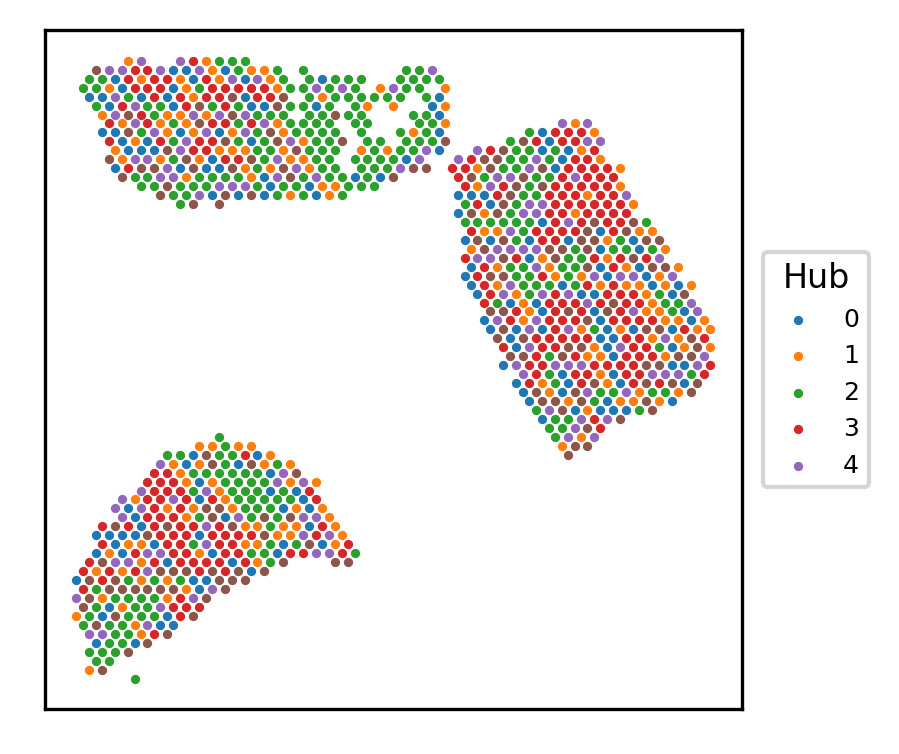

In [ ]:
all_loc = map_info.loc[:,['array_col','array_row']]

fig,axs= plt.subplots(1,1,figsize=(3,3),dpi=300)

for i in range(model.row_labels_.max()+1):
  g=axs.scatter(np.array(all_loc[hub_df['hub']==i].iloc[:,0]),-np.array(all_loc[hub_df['hub']==i].iloc[:,1]),s=1.5)
  
  axs.set_xticks([])
  axs.set_yticks([])

legend = plt.legend(range(model.row_labels_.max()),loc='right',bbox_to_anchor=(1.2,0.5),prop={'size': 6},title='Hub')
legend.get_title().set_fontsize('8')

Text(0.5, 1.0, 'Inferred image from integration')

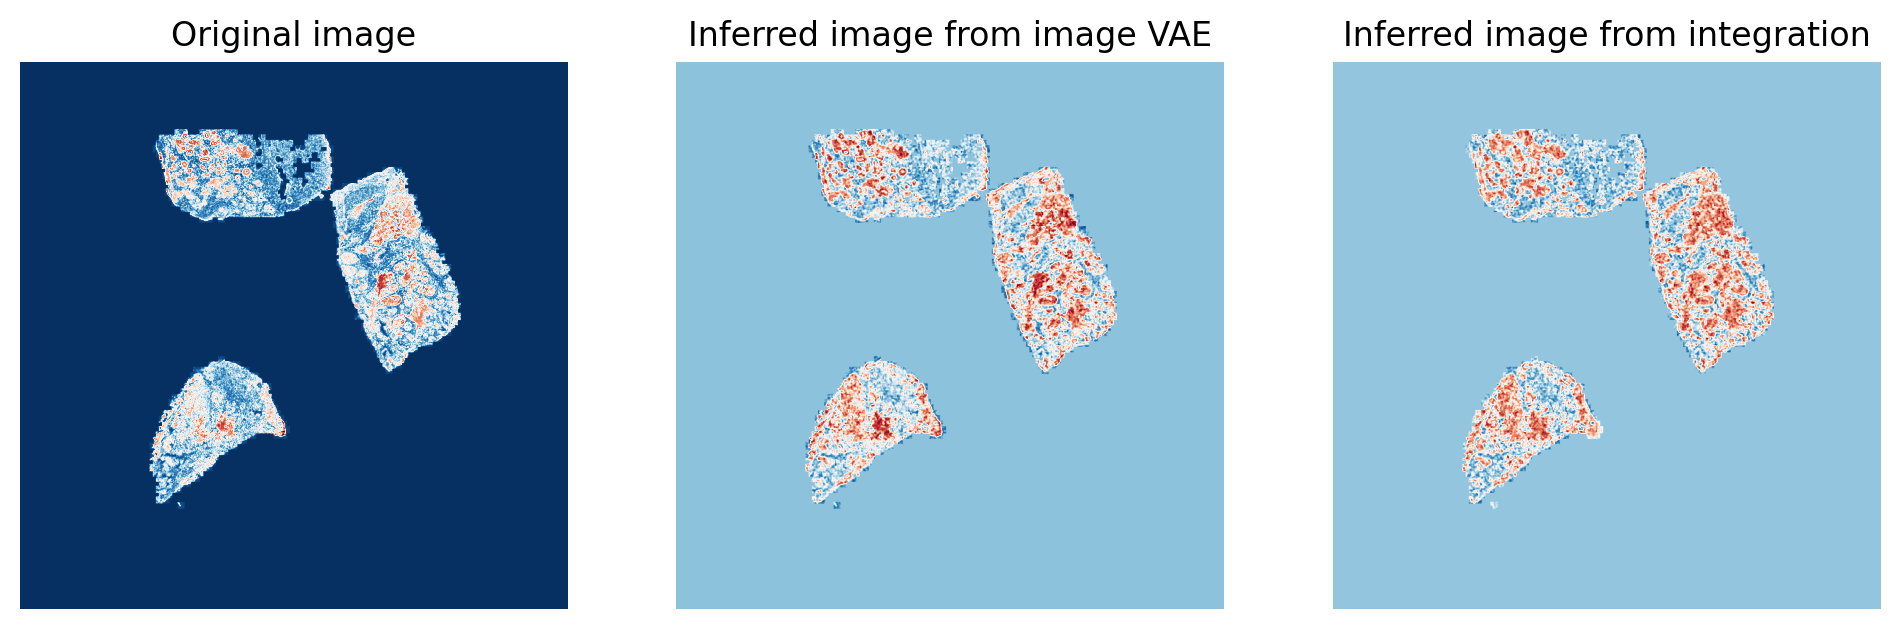

In [ ]:

fig,axs=plt.subplots(1,3,figsize=(12,5),dpi=200)
image_slide_z = 0
#vmax = 0.8
#vmin = 0

ax=axs[0]
ax.imshow(wholeimg_stitch[:,:,image_slide_z],cmap='RdBu_r',
          #vmax=vmax,vmin=vmin
          )
ax.axis('off')
ax.set_title('Original image')

ax=axs[1]
ax.imshow(recon_wholeimg_stitch[:,:,image_slide_z],cmap='RdBu_r',
          #vmax=vmax,vmin=vmin
          )
ax.axis('off')
ax.set_title('Inferred image from image VAE')

ax=axs[2]
ax.imshow(recon_poe_wholeimg_stitch[:,:,image_slide_z],cmap='RdBu_r',
          #vmax=vmax,vmin=vmin
          )
ax.axis('off')
ax.set_title('Inferred image from integration')

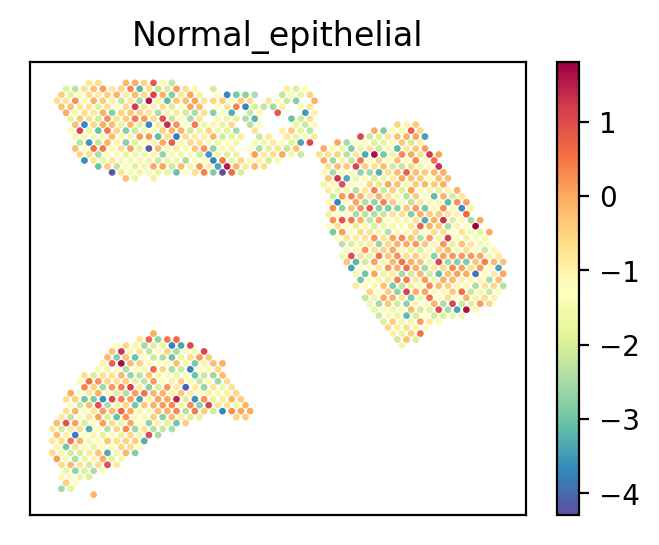

In [ ]:
c_max = 2
c_min = -2

image_slide_z = 1

#all_spot = mu_poe_stack_df[[spot_id.split('-')[-1]==sample_ids[image_slide_z]for spot_id in mu_poe_stack_df.index ]]
all_spot = mu_poe_stack_df

all_loc = np.array(map_info.loc[map_info['sample']==sample_id,['array_col','array_row']])

fig,axs= plt.subplots(1,1,figsize=(4,3),dpi=200)

for i in range(1):
    for j in range(1):
        #ax=axs[i,j]
        plotted_cell_idx = 24
        if plotted_cell_idx<mu_poe_stack_df.shape[1]:
            plotted_cell= mu_poe_stack_df.columns[plotted_cell_idx]

            #ddd = ddd/ddd.max()
            ddd = pd.DataFrame(all_spot.loc[:,plotted_cell])
            ddd = np.array(ddd)
            #ddd = np.array(ddd.T.apply(zscore).T)
            #ddd = (ddd-ddd.min())/(ddd.max()-ddd.min())
            #ddd = np.clip(ddd, -1, 2)
            g=axs.scatter(all_loc[:,0],-all_loc[:,1],s=2,c=ddd,cmap='Spectral_r')
            plt.colorbar(g, ax=axs)
            axs.set_title(plotted_cell)
            axs.set_xticks([])
            axs.set_yticks([])